In [8]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 160980 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.24-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.24-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.24-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

Import required libraries to use Google Colaboratory


In [9]:
!mkdir -p drive
!google-drive-ocamlfuse drive

Import libraries required to run experiment

In [10]:
import pandas as pd
import numpy as np
import itertools
import keras
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import Sequential
from keras import optimizers
from keras.preprocessing import image
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import math
import datetime
import time


In [27]:
  # set image dimensions
img_width, img_height = 256, 256

# create bottleneck file
top_model_weights_path = 'bottleneck_fc_model.h5'

# load dataset from directory
train_data_dir = '/content/drive/ColabNotebooks/data/train'
validation_data_dir = '/content/drive/ColabNotebooks/data/validation'

# set number of epochs and batch size
epochs = 50
batch_size = 181

Explore Pretrained Neural Network - VGG16
Transfer Learning Approach

In [12]:
# load vgg16 model
vgg16 = applications.VGG16(include_top=False, weights='imagenet')

datagen = ImageDataGenerator(rescale=1. / 255)

Create dataset using Keras generator class which performs image augmentation on the input images to create new dataset.
Also create bottleneck from vgg16

In [13]:
start = datetime.datetime.now()

generator = datagen.flow_from_directory(train_data_dir,
                                       target_size=(img_width, img_height),
                                       batch_size=batch_size,
                                       class_mode=None,
                                       shuffle=False)

nb_train_samples = len(generator.filenames)
num_classes = len(generator.class_indices)

predict_size_train = int(math.ceil(nb_train_samples / batch_size))

bottleneck_features_train = vgg16.predict_generator(generator, predict_size_train)

np.save('bottleneck_features_train.npy', bottleneck_features_train)
end = datetime.datetime.now()
elapsed = end-start
print('Time: ', elapsed)

Found 2897 images belonging to 6 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Time:  0:22:01.151957


In [14]:
# training data
generator_top = datagen.flow_from_directory(train_data_dir,
                                           target_size=(img_width, img_height),
                                           batch_size=batch_size,
                                           class_mode='categorical',
                                           shuffle=False)

nb_train_samples = len(generator_top.filenames)
num_classes = len(generator_top.class_indices)

# load the bottleneck features saved earlier
train_data = np.load('bottleneck_features_train.npy')
# get the class labels for the training data, in the original order
train_labels = generator_top.classes
#convert the training labels to categorical vectors
train_labels = to_categorical(train_labels, num_classes=num_classes)

Found 2897 images belonging to 6 classes.


In [15]:
start = datetime.datetime.now()

generator = datagen.flow_from_directory(validation_data_dir,
                                       target_size=(img_width, img_height),
                                       batch_size=batch_size,
                                       class_mode=None,
                                       shuffle=False)

nb_validation_samples = len(generator.filenames)
num_classes = len(generator.class_indices)

predict_size_val = int(math.ceil(nb_validation_samples / batch_size))

bottleneck_features_val = vgg16.predict_generator(generator, predict_size_val)

np.save('bottleneck_features_val.npy', bottleneck_features_val)
end = datetime.datetime.now()
elapsed = end-start
print('Time: ', elapsed)

Found 1368 images belonging to 6 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Time:  0:11:57.667855


In [16]:
# training data
generator_top = datagen.flow_from_directory(validation_data_dir,
                                           target_size=(img_width, img_height),
                                           batch_size=batch_size,
                                           class_mode='categorical',
                                           shuffle=False)

nb_val_samples = len(generator_top.filenames)
num_classes = len(generator_top.class_indices)

# load the bottleneck features saved earlier
val_data = np.load('bottleneck_features_val.npy')
# get the class labels for the training data, in the original order
val_labels = generator_top.classes
#convert the training labels to categorical vectors
val_labels = to_categorical(val_labels, num_classes=num_classes)

Found 1368 images belonging to 6 classes.


Simple Final layers for the model. See Transfer learning for more information

In [17]:
start = datetime.datetime.now()
model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(100, activation=keras.layers.LeakyReLU(alpha=0.3)))
model.add(Dropout(0.5))
model.add(Dense(50, activation=keras.layers.LeakyReLU(alpha=0.3)))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
             optimizer=optimizers.RMSprop(lr=1e-4),
             metrics=['acc'])

history = model.fit(train_data, train_labels, epochs=50,
                   batch_size=batch_size,
                   validation_data=(val_data, val_labels))
model.save_weights(top_model_weights_path)
(eval_loss, eval_accuracy) = model.evaluate( 
    val_data, val_labels, batch_size=batch_size,verbose=1)
print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100)) 
print("[INFO] Loss: {}".format(eval_loss)) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Epoch 1/50
17/17 [==============================] - 1s 33ms/step - loss: 1.6493 - acc: 0.4233 - val_loss: 0.8321 - val_acc: 0.7325
Epoch 2/50
17/17 [==============================] - 0s 21ms/step - loss: 0.7313 - acc: 0.7441 - val_loss: 0.6112 - val_acc: 0.7697
Epoch 3/50
17/17 [==============================] - 0s 21ms/step - loss: 0.5332 - acc: 0.8230 - val_loss: 0.6999 - val_acc: 0.7069
Epoch 4/50
17/17 [==============================] - 0s 22ms/step - loss: 0.5137 - acc: 0.8278 - val_loss: 0.6231 - val_acc: 0.7727
Epoch 5/50
17/17 [==============================] - 0s 21ms/step - loss: 0.4330 - acc: 0.8627 - val_loss: 0.6315 - val_acc: 0.7683
Epoch 6/50
17/17 [==============================] - 0s 21ms/step - loss: 0.3774 - acc: 0.8665 - val_loss: 0.4849 - val_acc: 0.8289
Epoch 7/50
17/17 [==============================] - 0s 22ms/step - loss: 0.3399 - acc: 0.8856 - val_loss: 0.5857 - val_acc: 0.7844
Epoch 8/50
17/17 [==============================] - 0s 21ms/step - loss: 0.3378 - a

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 100)               3276900   
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 306       
Total params: 3,282,256
Trainable params: 3,282,256
Non-trainable params: 0
______________________________________________

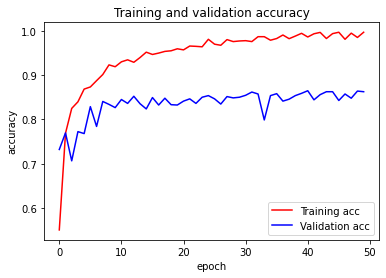

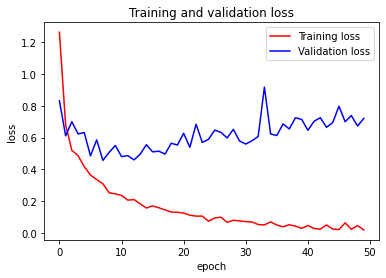

In [18]:
#Graphing our training and validation
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy') 
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss') 
plt.xlabel('epoch')
plt.legend()
plt.show()

In [19]:
import numpy as np
preds = np.round(model.predict(val_data),0)
print('rounded val data',preds)

rounded val data [[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]]


In [20]:
classes = ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy', 'Maize_Leaf_Downy_Mildew', 'Maize_Leaf_Streak_Virus']

In [21]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
classification_metrics = metrics.classification_report(val_labels,preds, target_names=classes)
print(classification_metrics)

                         precision    recall  f1-score   support

                 Blight       0.80      0.79      0.79       324
            Common_Rust       0.90      0.89      0.89       396
         Gray_Leaf_Spot       0.83      0.73      0.77       228
                Healthy       0.93      1.00      0.96       396
Maize_Leaf_Downy_Mildew       0.80      0.33      0.47        12
Maize_Leaf_Streak_Virus       0.57      0.33      0.42        12

              micro avg       0.87      0.86      0.87      1368
              macro avg       0.80      0.68      0.72      1368
           weighted avg       0.87      0.86      0.86      1368
            samples avg       0.86      0.86      0.86      1368



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
#Since our data is in dummy format we put the numpy array into a dataframe and call idxmax axis=1 to return the column
# label of the maximum value thus creating a categorical variable
#Basically, flipping a dummy variable back to it’s categorical variable
categorical_test_labels = pd.DataFrame(val_labels).idxmax(axis=1)
categorical_preds = pd.DataFrame(preds).idxmax(axis=1)
confusion_matrix= confusion_matrix(categorical_test_labels, categorical_preds)

#To get better visual of the confusion matrix:
def plot_confusion_matrix(cm, classes,
   normalize=False,
   title='Confusion matrix',
   cmap=plt.cm.Blues):
 
#Add Normalization Option
 #prints pretty confusion metric with normalization option ‘’’
   if normalize:
     cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
     print("Normalized confusion matrix")
   else:
     print('Confusion matrix, without normalization')
 
# print(cm)
 
   plt.imshow(cm, interpolation='nearest', cmap=cmap)
   plt.title(title)
   plt.colorbar()
   tick_marks = np.arange(len(classes))
   plt.xticks(tick_marks, classes, rotation=45)
   plt.yticks(tick_marks, classes)
 
   fmt = '.2f' if normalize else 'd'
   thresh = cm.max() / 2.
   for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')
 
   plt.tight_layout()
   plt.ylabel('True label')
   plt.xlabel('Predicted label')

Normalized confusion matrix


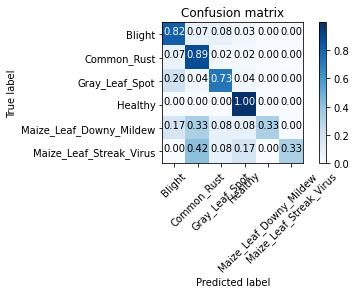

In [24]:
plot_confusion_matrix(confusion_matrix,classes,normalize=True)

[INFO] loading and preprocessing image…


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


ID: 0, Label: Blight 0.01%
ID: 1, Label: Common_Rust 9.08%
ID: 2, Label: Gray_Leaf_Spot 83.18%
ID: 3, Label: Healthy 0.05%
ID: 4, Label: Maize_Leaf_Downy_Mildew 0.35%
ID: 5, Label: Maize_Leaf_Streak_Virus 7.34%
Final Decision:
.
..
...
ID: 2, Label: Gray_Leaf_Spot


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


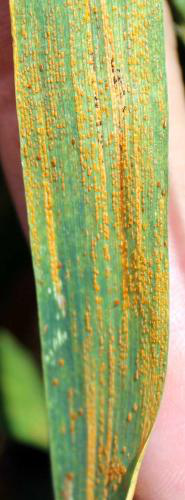

In [26]:
def read_image(file_path):
   print("[INFO] loading and preprocessing image…") 
   image = load_img(file_path, target_size=(256, 256)) 
   image = img_to_array(image) 
   image = np.expand_dims(image, axis=0)
   image /= 255. 
   return image
def test_single_image(path):
  images = read_image(path)
  time.sleep(.5)
  bt_prediction = vgg16.predict(images) 
  preds = model.predict_proba(bt_prediction)
  for idx, animal, x in zip(range(0,6), classes , preds[0]):
   print("ID: {}, Label: {} {}%".format(idx, animal, round(x*100,2) ))
  print('Final Decision:')
  time.sleep(.5)
  for x in range(3):
   print('.'*(x+1))
   time.sleep(.2)
  class_predicted = model.predict_classes(bt_prediction)
  class_dictionary = generator_top.class_indices 
  inv_map = {v: k for k, v in class_dictionary.items()} 
  print("ID: {}, Label: {}".format(class_predicted[0],  inv_map[class_predicted[0]])) 
  return load_img(path)
path = '/content/drive/ColabNotebooks/data/rust.jpg'
test_single_image(path)